# Attempt regression on 5G sequences but using a very simple motif scoring system. Check if augmentation can help regression (if needed)

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [18]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og['gene'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['gene'])
XYdf_og['product'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['product'])
XYdf_og['type'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['type'])

XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,NaN,transposase,CDS


In [10]:
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

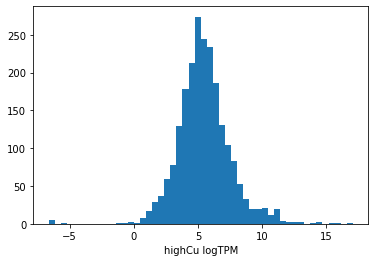

In [19]:
plt.hist(XYdf_og['highCu'],bins=50)
plt.xlabel("highCu logTPM")
plt.show()

In [22]:
XYdf_og[XYdf_og['upstream_region'].str.contains("N")]

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
2112,4034,EQU24_RS22155,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,10.239025,10.11798,8.934446,8.077251,9.814282,10.3885,10.558184,...,8.219765,8.270905,9.208331,9.285992,9.331448,7.736552,7.289285,rpmH,50S ribosomal protein L34,CDS


In [23]:
# remove seq with N's for now
XYdf = XYdf_og[~XYdf_og['upstream_region'].str.contains("N")]
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,NaN,transposase,CDS


## Add fake score column

In [58]:
m1 = "TAT"
m2 = "GCG"

score_dict = {
    'A':20,
    'C':10,
    'G':0,
    'T':-10
}

def score_seq(seq):
    score = np.mean([score_dict[base] for base in seq])
    if 'TATATA' in seq:
        score += 10
    if 'GCGCGC' in seq:
        score -= 10
    return score


In [59]:
XYdf['score'] = XYdf['upstream_region'].apply(lambda x: score_seq(x))
#XYdf_og['posc_seq'] = XYdf_og['upstream_region'].apply(lambda x: x.strip("N")[:6])
XYdf

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,score
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,dnaA,chromosomal replication initiator protein DnaA,CDS,3.333333
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,dnaN,DNA polymerase III subunit beta,CDS,4.633333
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,recF,DNA replication/repair protein RecF,CDS,4.766667
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,NaN,hypothetical protein,CDS,5.666667
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS,4.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,hxlA,3-hexulose-6-phosphate synthase,CDS,6.100000
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,hxlA,3-hexulose-6-phosphate synthase,CDS,6.100000
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,hxlA,3-hexulose-6-phosphate synthase,CDS,4.400000
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,NaN,transposase,CDS,4.300000


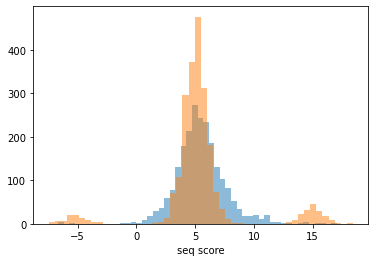

In [60]:
plt.hist(XYdf['highCu'],bins=50,alpha=0.5)
plt.hist(XYdf['score'],bins=50,alpha=0.5)
plt.xlabel("seq score")
plt.show()

### Train/val/test splitting

In [64]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='score')
    
    sns.stripplot(data=df_melt,x='cond',y='score',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.violinplot(data=df_melt,x='cond',y='score',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.boxplot(data=df_melt,x='cond',y='score',hue='set',dodge=True)
    plt.title(f"{title} distribution")
    plt.show()


In [65]:
full_train_df,test_df = tu.quick_split(XYdf)
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

full train: (1768, 25)
test: (442, 25)
train: (1414, 26)
val: (354, 26)


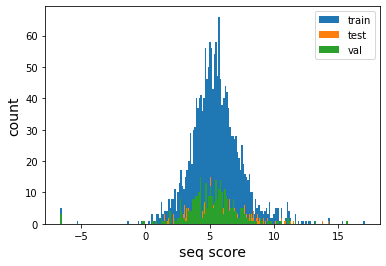

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  after removing the cwd from sys.path.


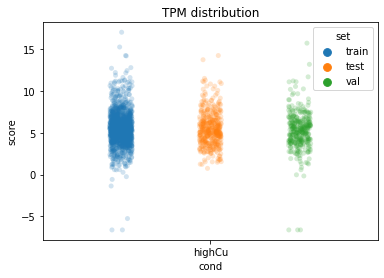

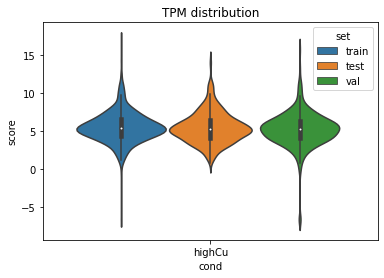

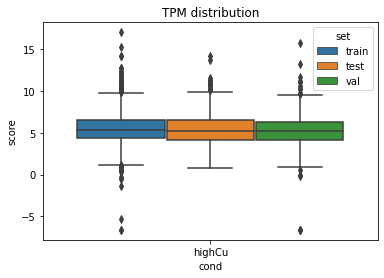

In [66]:
score_col = "highCu"

plot_train_test_hist(full_train_df, test_df,score_col=score_col,bins=200,val_df=val_df)
view_train_test_dist(train_df, test_df,[score_col],"TPM",id_col='locus_tag',val_df=val_df)


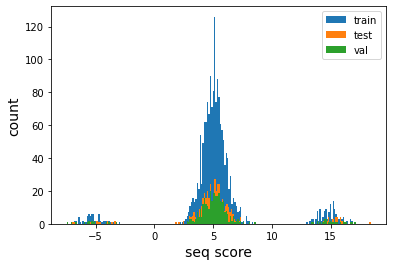

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  after removing the cwd from sys.path.


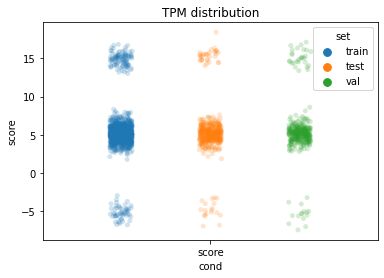

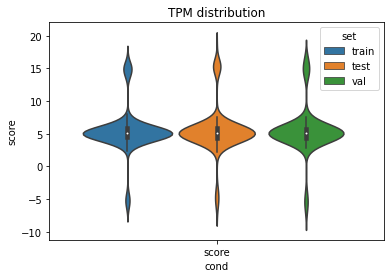

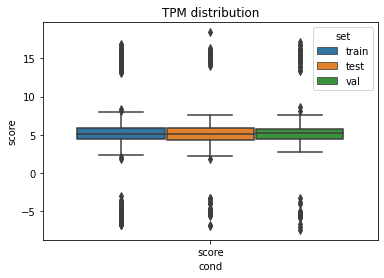

In [67]:
score_col = "score"

plot_train_test_hist(full_train_df, test_df,score_col=score_col,bins=200,val_df=val_df)
view_train_test_dist(train_df, test_df,[score_col],"TPM",id_col='locus_tag',val_df=val_df)


In [78]:
split_dfs = {
    #'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

## Load 5G seqs into data loaders

In [69]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

In [70]:
seq_col_name = 'upstream_region'
target_col_name = 'score'

# Dfs for the full train/test split
final_dls = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name
)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

## Run models

In [72]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=False):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            1, # num tasks
        )
    model.to(DEVICE)

    loss_func = torch.nn.MSELoss() 
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best # leave false to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [73]:
def parity_pred_by_split(model_name,
                         device,
                         split_dfs,
                         locus_col='locus_tag',
                         seq_col='seq',
                         target_col="score",
                         splits=['train','val'],
                         alpha=0.2
                        ):
    '''
    Given a trained model, get the model's predictions on each split
    of the data and create parity plots of the y predictions vs actual ys
    '''
    # init subplots
    fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
    pred_dfs = {}
    
    def parity_plot(model_title,ytrue,ypred,rigid=True):
        axs[i].scatter(ytrue, ypred, alpha=alpha)

        r2 = r2_score(ytrue,ypred)
        pr = pearsonr(ytrue,ypred)[0]
        sp = spearmanr(ytrue,ypred).correlation

        # y=x line
        xpoints = ypoints = plt.xlim()
        if rigid:
            axs[i].set_ylim(min(xpoints),max(xpoints)) 
        axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
        axs[i].set_xlabel("Actual Score",fontsize=14)
        axs[i].set_ylabel("Predicted Score",fontsize=14)
    
    for i,split in enumerate(splits):
        print(f"{split} split")
        df = split_dfs[split]
        loci = df[locus_col].values
        seqs = list(df[seq_col].values)        
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
        labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    #dfs = {} # key: model name, value: parity_df
    
        # initialize prediction df with just locus col
        pred_df = df[[locus_col]]
        pred_df['truth'] = df[target_col]
        print(f"Running {model_name}")
        
        model = model_res[model_name]['model']
        # ask model to predict on seqs
        preds = model(ohe_seqs.float()).tolist()
        # preds is a tensor converted to a list, 
        # single elements returned as a list, hence x[0]
        pred_df['pred'] = [x[0] for x in preds]
        
        # do I want the result dfs? revise if so
        #dfs[model_name] = pred_df
        
        # plot stuff
        ytrue = pred_df['truth'].values
        ypred = pred_df['pred'].values
        
        #plt.subplot(len(splits),i+1,1)
        model_title = split
        parity_plot(model_title,ytrue,ypred,rigid=True)
        
        # save predictions
        pred_dfs[split] = pred_df
    
    
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return pred_dfs

In [76]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col_name].values[0])

E:139 | train loss:15.798 | val loss: 15.912:   7%|▋         | 139/2000 [00:07<01:32, 20.06it/s]

EarlyStopping counter: 50 out of 200


E:189 | train loss:5.204 | val loss: 15.104:  10%|▉         | 190/2000 [00:09<01:29, 20.14it/s] 

EarlyStopping counter: 100 out of 200


E:239 | train loss:3.074 | val loss: 15.372:  12%|█▏        | 238/2000 [00:12<01:27, 20.24it/s]

EarlyStopping counter: 150 out of 200


E:285 | train loss:2.548 | val loss: 15.705:  14%|█▍        | 285/2000 [00:14<01:26, 19.90it/s]


EarlyStopping counter: 200 out of 200
Early stopping


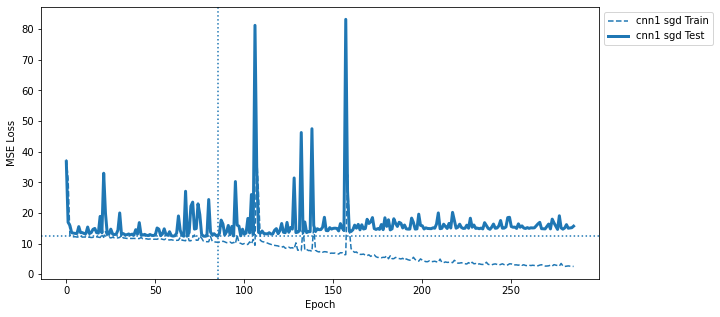

In [77]:
cnn1_name = 'cnn1 sgd'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn1 sgd
val split
Running cnn1 sgd
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn1 sgd


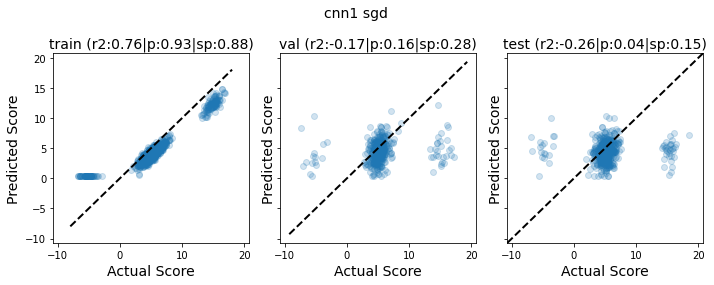

In [80]:
pred_dfs[cnn1_name] = parity_pred_by_split(cnn1_name,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

E:182 | train loss:3.952 | val loss: 14.229:   4%|▎         | 183/5000 [00:10<04:20, 18.52it/s] 

EarlyStopping counter: 125 out of 500


E:307 | train loss:1.326 | val loss: 16.075:   6%|▌         | 307/5000 [00:16<04:13, 18.51it/s]

EarlyStopping counter: 250 out of 500


E:432 | train loss:0.955 | val loss: 15.216:   9%|▊         | 433/5000 [00:23<04:06, 18.49it/s]

EarlyStopping counter: 375 out of 500


E:554 | train loss:0.754 | val loss: 14.399:  11%|█         | 554/5000 [00:30<04:02, 18.30it/s]


EarlyStopping counter: 500 out of 500
Early stopping


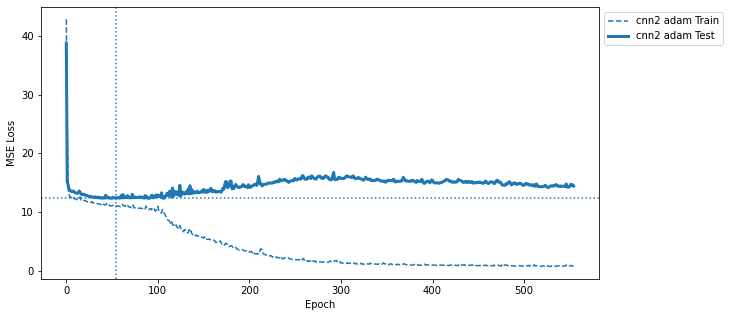

In [82]:
cnn2_name = 'cnn2 adam'
model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn2 adam
val split
Running cnn2 adam
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn2 adam


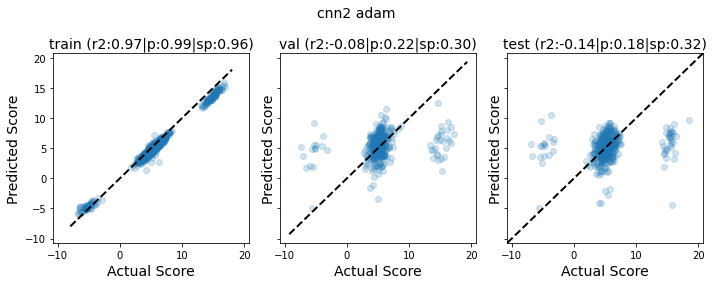

In [83]:
pred_dfs[cnn2_name] = parity_pred_by_split(cnn2_name,
                                DEVICE,
                                split_dfs,
                                locus_col='locus_tag',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

E:295 | train loss:9.930 | val loss: 12.544:   6%|▌         | 296/5000 [00:16<04:11, 18.70it/s] 

EarlyStopping counter: 125 out of 500


E:420 | train loss:7.977 | val loss: 13.556:   8%|▊         | 420/5000 [00:22<04:05, 18.69it/s] 

EarlyStopping counter: 250 out of 500


E:545 | train loss:6.507 | val loss: 14.058:  11%|█         | 546/5000 [00:29<03:57, 18.72it/s]

EarlyStopping counter: 375 out of 500


E:667 | train loss:5.428 | val loss: 14.316:  13%|█▎        | 667/5000 [00:36<03:53, 18.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


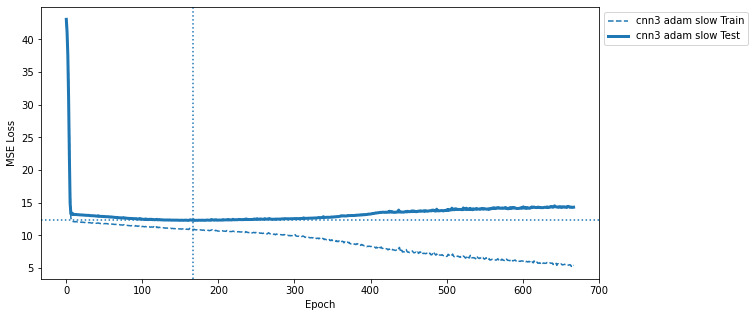

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn3 adam slow
val split
Running cnn3 adam slow
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn3 adam slow


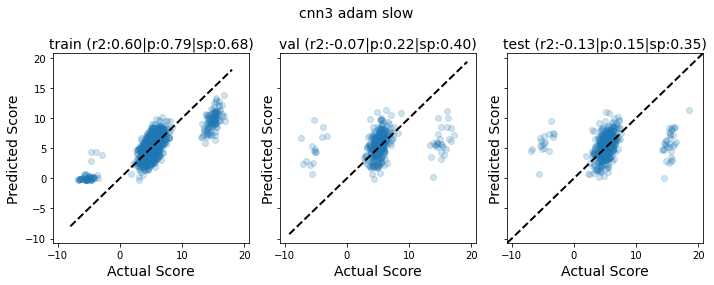

In [84]:
cnn3_name = 'cnn3 adam slow'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn3_name] = parity_pred_by_split(cnn3_name,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

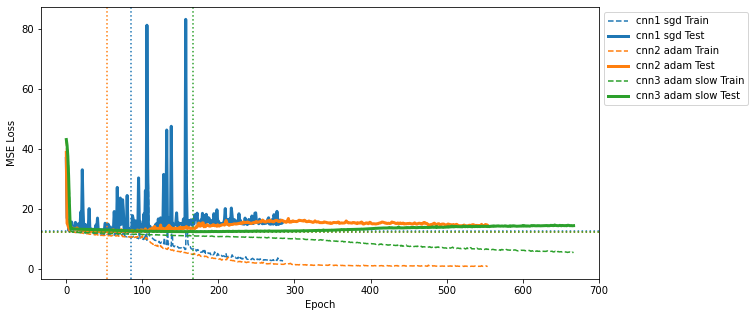

In [85]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [86]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.03):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G']
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])

In [88]:
aug_train_df = augment_mutate(train_df,10)
aug_train_df

,level_0,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,...,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,score,set,seq_version
1,2,2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,...,3.507901,4.979830,4.642674,4.258694,recF,DNA replication/repair protein RecF,CDS,4.766667,train,0
2,3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,...,5.577019,6.052065,6.409572,6.737678,NaN,hypothetical protein,CDS,5.666667,train,0
3,4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,...,4.354762,4.450588,4.012562,4.059889,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS,4.566667,train,0
4,5,5,12,EQU24_RS00080,CCCAGACTGAACGCAACAGGATCGATATTAGGATAAGTCAGCATTT...,3.504904,2.823659,2.764909,2.814877,2.993438,...,2.201298,3.045767,3.336137,3.186492,NaN,2OG-Fe(II) oxygenase,CDS,5.133333,train,0
5,6,6,13,EQU24_RS00085,TTACCGGGCCGGATTTTTTGACATAGTTCGTTTAGGGTTGGCAATT...,5.889536,5.238740,5.182750,4.729318,5.149217,...,5.401099,6.276210,4.992318,4.985268,lgt,prolipoprotein diacylglyceryl transferase,CDS,4.666667,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,2209,2210,4188,EQU24_RS23175,GACAACAAATGAATATGATTCGTCATCCGAACGAAAGCGTCAAGCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,1.313992,2.970741,0.101289,-0.419729,NaN,type II toxin-antitoxin system RelE/ParE famil...,CDS,5.333333,train,6
14136,2209,2210,4188,EQU24_RS23175,GACAACAAGTGAACATTATTCGTCATCTGAACGAAAGCGTAAAGCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,1.313992,2.970741,0.101289,-0.419729,NaN,type II toxin-antitoxin system RelE/ParE famil...,CDS,5.333333,train,7
14137,2209,2210,4188,EQU24_RS23175,GACAACAAATGAACACGATTCGTCATCTGAACGAAAGCGTAAAGCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,1.313992,2.970741,0.101289,-0.419729,NaN,type II toxin-antitoxin system RelE/ParE famil...,CDS,5.333333,train,8
14138,2209,2210,4188,EQU24_RS23175,GACAACAAATGAACATGACTCGTCATCTTAACGAAAGCGTAAAGCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,1.313992,2.970741,0.101289,-0.419729,NaN,type II toxin-antitoxin system RelE/ParE famil...,CDS,5.333333,train,9


In [90]:
aug_dls = tu.build_dataloaders_single(
    aug_train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

aug_ohe_train_dl,aug_ohe_val_dl = aug_dls['ohe']

E:142 | train loss:1.274 | val loss: 14.199:   3%|▎         | 143/5000 [01:08<38:53,  2.08it/s]

EarlyStopping counter: 125 out of 500


E:424 | train loss:0.050 | val loss: 12.471:   8%|▊         | 425/5000 [03:24<36:50,  2.07it/s]

EarlyStopping counter: 125 out of 500


E:549 | train loss:0.039 | val loss: 12.422:  11%|█         | 550/5000 [04:24<35:54,  2.07it/s]

EarlyStopping counter: 250 out of 500


E:674 | train loss:0.034 | val loss: 12.641:  14%|█▎        | 675/5000 [05:25<34:52,  2.07it/s]

EarlyStopping counter: 375 out of 500


E:799 | train loss:0.033 | val loss: 12.562:  16%|█▌        | 799/5000 [06:25<33:47,  2.07it/s]

EarlyStopping counter: 500 out of 500
Early stopping


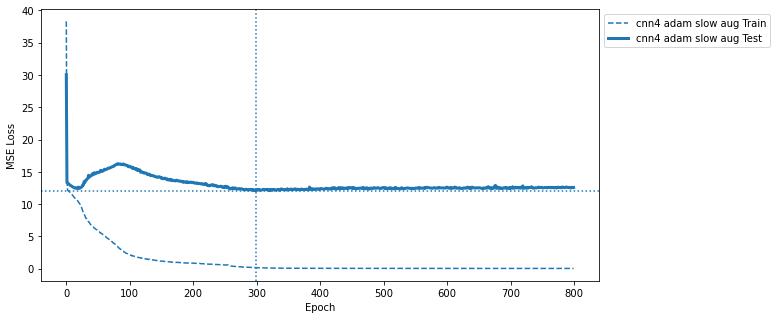

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn4 adam slow aug
val split
Running cnn4 adam slow aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 adam slow aug


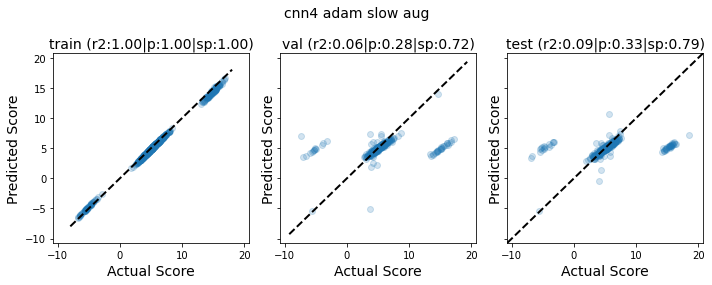

In [91]:
cnn4_name = 'cnn4 adam slow aug'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn4_name] = parity_pred_by_split(cnn4_name,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

In [93]:
target_col_name

'score'

In [ ]:
cnn_tinker = 'cnn tinker_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=10,
    fc_node_num2=10,
    dropout1=0.25
)

model_res[cnn_tinker] = collect_model_stats(
    cnn_tinker,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0005,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

pred_dfs[cnn_tinker] = parity_pred_by_split(cnn_tinker,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

E:204 | train loss:2.960 | val loss: 12.991:   4%|▍         | 205/5000 [01:57<45:50,  1.74it/s]

EarlyStopping counter: 125 out of 500


E:329 | train loss:1.773 | val loss: 12.615:   7%|▋         | 330/5000 [03:09<44:43,  1.74it/s]

EarlyStopping counter: 250 out of 500


E:454 | train loss:1.387 | val loss: 12.325:   9%|▉         | 455/5000 [04:21<43:31,  1.74it/s]

EarlyStopping counter: 375 out of 500


E:470 | train loss:1.444 | val loss: 12.218:   9%|▉         | 471/5000 [04:30<43:16,  1.74it/s]

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn tinker_aug
val split
Running cnn tinker_aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn tinker_aug


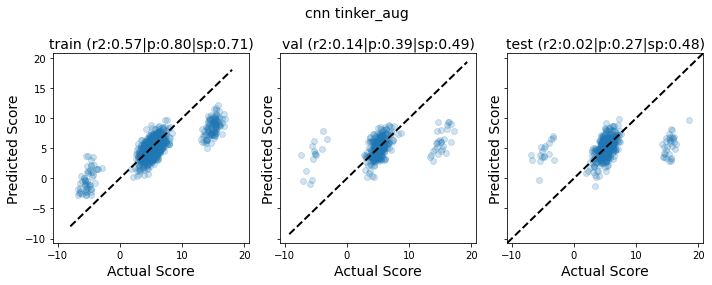

In [96]:
pred_dfs[cnn_tinker] = parity_pred_by_split(cnn_tinker,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )